# Anomaly detection with embeddings

In [ ]:
%pip install -U -q "google-genai>=1.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
from google import genai
API_KEY = "API_KEY"
client = genai.Client(api_key=API_KEY)

## 1. Data Preparation
The `20 Newsgroups dataset` is a collection of approximately 20,000 newsgroup documents, organized into 20 categories. It was originally collected from Usenet newsgroups in the late 1990s and is commonly used for text classification and natural language processing (NLP) tasks. The dataset contains articles or posts that were shared in various Usenet newsgroups

In [ ]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
idx = newsgroups_train.data[0].index("Lines")
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## 2. Text Preprocessing for Newsgroups Dataset

The following preprocessing steps are applied to clean and prepare the text data in the `newsgroups_train` dataset


In [ ]:
import re

# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [
    re.sub(r"[\w\.-]+@[\w\.-]+", "", d) for d in newsgroups_train.data
]  # Remove email
newsgroups_train.data = [
    re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data
]  # Remove names
newsgroups_train.data = [
    d.replace("From: ", "") for d in newsgroups_train.data
]  # Remove "From: "
newsgroups_train.data = [
    d.replace("\nSubject: ", "") for d in newsgroups_train.data
]  # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [
    d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data
]

In [ ]:
import pandas as pd

# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=["Text"])

df_train["Label"] = newsgroups_train.target

# Match label to target name index
df_train["Class Name"] = df_train["Label"].map(
    newsgroups_train.target_names.__getitem__
)

df_train


,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


In [ ]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (
    df_train.groupby("Label", as_index=False)
    .apply(lambda x: x.sample(SAMPLE_SIZE))
    .reset_index(drop=True)
)

# Choose categories about science
df_train = df_train[df_train["Class Name"].str.contains("sci")]

# Reset the index
df_train = df_train.reset_index()
df_train

<ipython-input-15-dc22d2141534>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


,index,Text,Label,Class Name
0,1650,IDEA vectors?\nOrganization: capriccioso\nX-N...,11,sci.crypt
1,1651,"Re: Once tapped, your code is no good any mor...",11,sci.crypt
2,1652,"Re: Once tapped, your code is no good any mor...",11,sci.crypt
3,1653,Re: Source of random bits on a Unix workstati...,11,sci.crypt
4,1654,Re: Clipper Crypto\nOrganization: Stratus Com...,11,sci.crypt
...,...,...,...,...
595,2245,"Re: Guns for Space\nKeywords: Sopa Gun, Space...",14,sci.space
596,2246,Re: Big amateur rockets\nOrganization: NCR Co...,14,sci.space
597,2247,Re: pushing the envelope\nArticle-I.D.: rave....,14,sci.space
598,2248,Re: nuclear waste\nOrganization: Private Comp...,14,sci.space


In [ ]:
df_train["Class Name"].value_counts()

,count
Class Name,
sci.crypt,150
sci.electronics,150
sci.med,150
sci.space,150


## 3. Create Embeddings

In [ ]:
from tqdm.auto import tqdm
from google.genai import types

tqdm.pandas()

from google.api_core import retry
import numpy as np
import math

def make_text_embed(model):
   @retry.Retry(timeout=300.0)
   def embed_fn(texts: list[str]) -> list[list[float]]:
        # Set the task_type to CLUSTERING and embed the batch of texts
        embeddings = client.models.embed_content(
            model=model,
            contents=texts,
            config=types.EmbedContentConfig(task_type="CLUSTERING"),
        ).embeddings
        return np.array([embedding.values for embedding in embeddings])

   return embed_fn

In [ ]:
def create_embeddings(df):
    MODEL_ID = "text-embedding-004" # @param ["embedding-001","text-embedding-004"] {allow-input: true}
    model = f"models/{MODEL_ID}"
    embed_fn = make_text_embed(model)

    batch_size = 100
    all_embeddings = []

    # Loop over the texts in chunks of batch_size
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["Text"].iloc[i : i + batch_size].tolist()
        embeddings = embed_fn(batch)
        all_embeddings.extend(embeddings)

    df["Embeddings"] = all_embeddings
    return df


df_train = create_embeddings(df_train)
df_train.drop("index", axis=1, inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

## 4. Dimensionality Reduction


In [ ]:
len(df_train["Embeddings"][0])

768

In [ ]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train["Embeddings"].to_list(), dtype=np.float32)
X.shape

(600, 768)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

In [ ]:
df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne['Class Name'] = df_train['Class Name']
df_tsne

,TSNE1,TSNE2,Class Name
0,-15.211569,-24.943525,sci.crypt
1,-17.667921,2.895512,sci.crypt
2,-15.603286,-3.441887,sci.crypt
3,-28.838940,-18.528574,sci.crypt
4,-16.279150,-11.218754,sci.crypt
...,...,...,...
595,5.404871,4.110074,sci.space
596,12.016080,3.809992,sci.space
597,-0.788038,3.481642,sci.space
598,22.606054,-1.998042,sci.space


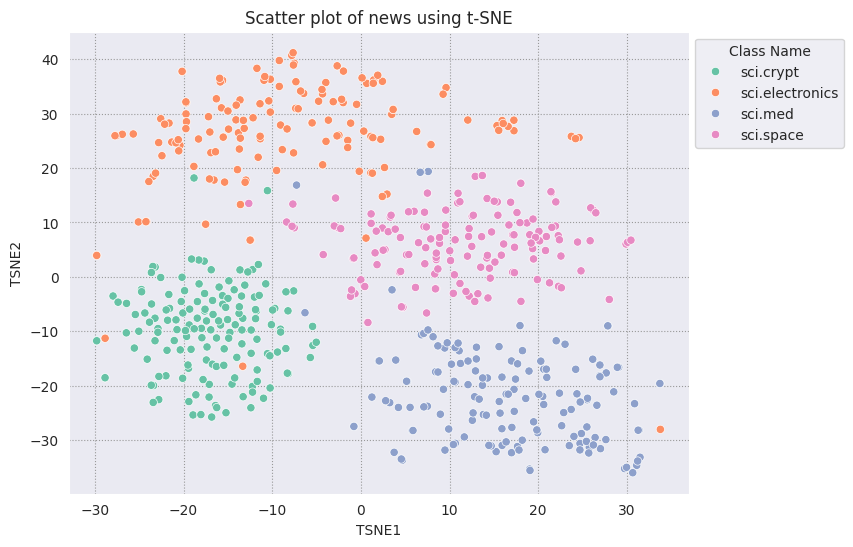

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(
    x='TSNE1',
    y='TSNE2',
    hue='Class Name',
    data=df_tsne,
    palette="Set2"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

## 5. Outlier Detection
To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [ ]:
def centroids(df_tsne):
    centroids = df_tsne.groupby('Class Name').mean().reset_index()
    return centroids

centroids = centroids(df_tsne)
centroids

,Class Name,TSNE1,TSNE2
0,sci.crypt,-16.939554,-9.892231
1,sci.electronics,-8.047864,25.961351
2,sci.med,16.660059,-21.386324
3,sci.space,11.192559,5.971171


In [ ]:
def get_embedding_centroids(df):
    emb_centroids = dict()
    grouped = df.groupby("Class Name")
    for c in grouped.groups:
        sub_df = grouped.get_group(c)
        # Get the centroid value of dimension 768
        emb_centroids[c] = np.mean(sub_df["Embeddings"], axis=0)

    return emb_centroids

emb_c = get_embedding_centroids(df_train)

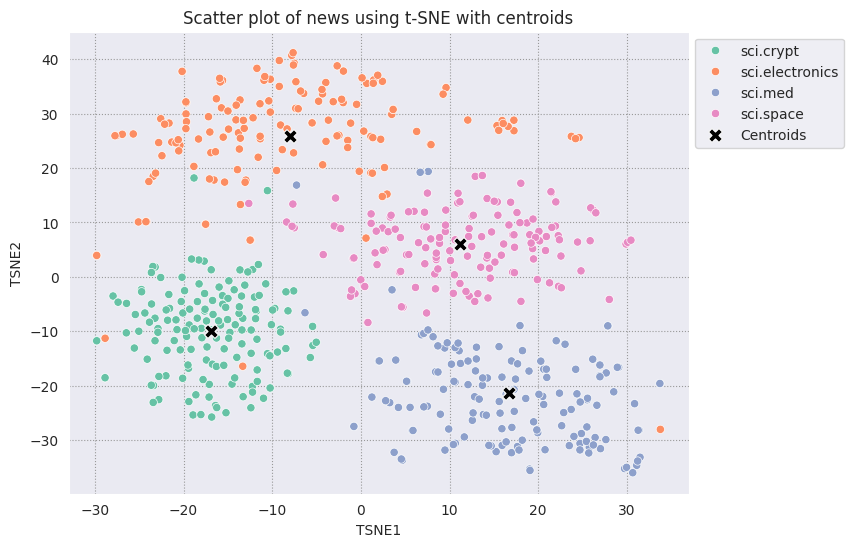

In [ ]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE with centroids")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

In [ ]:
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))


def detect_outlier(df, emb_centroids, radius):
    for idx, row in df.iterrows():
        class_name = row["Class Name"]
        # Compare centroid distances
        dist = calculate_euclidean_distance(
            row["Embeddings"], emb_centroids[class_name]
        )
        df.at[idx, "Outlier"] = dist > radius

    return len(df[df["Outlier"] == True])

In [ ]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
    num_outliers.append(detect_outlier(df_train, emb_c, i))

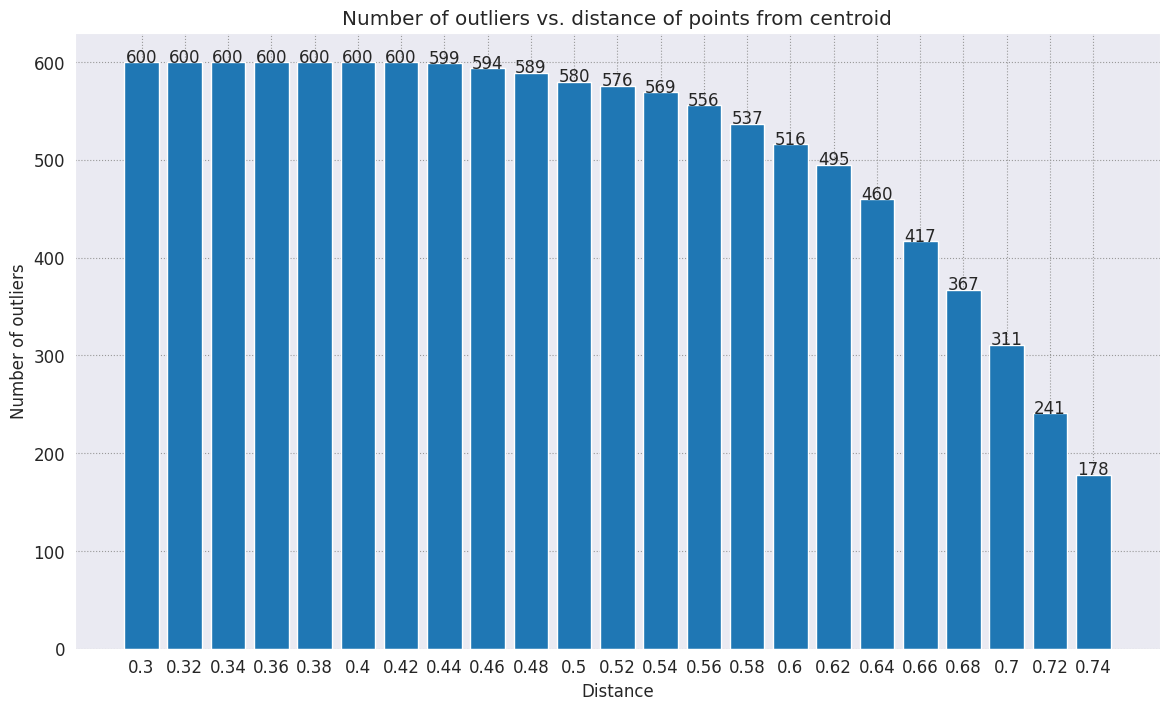

In [ ]:
# Plot range_ and num_outliers
fig = plt.figure(figsize=(14, 8))
plt.rcParams.update({"font.size": 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
    plt.text(i, num_outliers[i], num_outliers[i], ha="center")

plt.show()

In [ ]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train["Outlier"] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
0,IDEA vectors?\nOrganization: capriccioso\nX-N...,11,sci.crypt,"[-0.005800428, -0.012419313, -0.040541425, 0.0...",True
1,"Re: Once tapped, your code is no good any mor...",11,sci.crypt,"[0.038788956, 0.019615475, -0.08450243, 0.0342...",True
3,Re: Source of random bits on a Unix workstati...,11,sci.crypt,"[-0.03001118, 0.02444099, -0.08313023, 0.00908...",True
5,Re: Off the shelf cheap DES keyseach machine ...,11,sci.crypt,"[0.0009541601, -0.03307402, -0.02372139, 0.048...",True
6,"Re: Once tapped, your code is no good any mor...",11,sci.crypt,"[0.013247965, -0.0051974077, -0.0095170615, 0....",True


In [ ]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers["Outlier"].index]

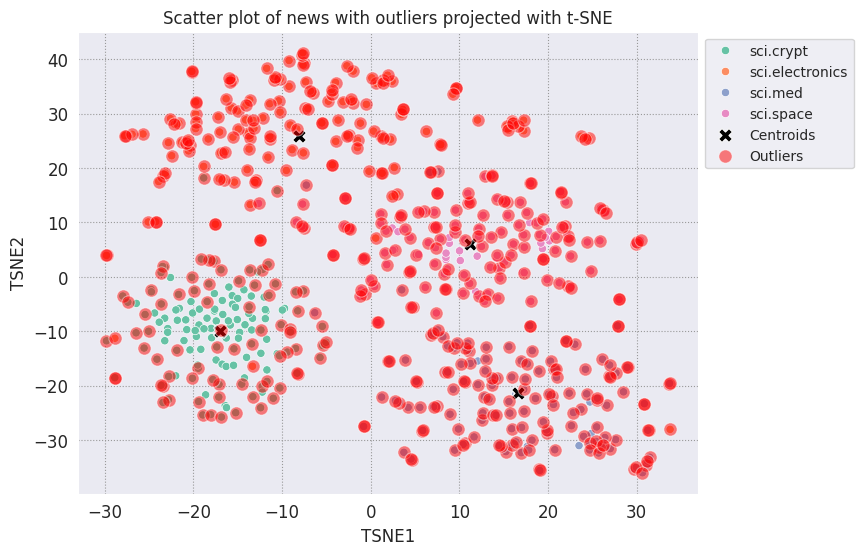

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
plt.rcParams.update({"font.size": 10})
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
# Draw a red circle around the outliers
sns.scatterplot(
    data=outliers_projected,
    x="TSNE1",
    y="TSNE2",
    color="red",
    marker="o",
    alpha=0.5,
    s=90,
    label="Outliers",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news with outliers projected with t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

In [ ]:
sci_crypt_outliers = df_outliers[df_outliers["Class Name"] == "sci.crypt"]
print(sci_crypt_outliers["Text"].iloc[0])

 IDEA vectors?
Organization: capriccioso
X-Newsreader: TIN [version 1.1 PL6]
Lines: 11

I am testing IDEA block cipher implementations for correctness
and needs some golden test vectors.  I've looked through
the postscript IDEA chapter but the single example gives me
zero degrees of freedom.  I'll contact the inventor if necessary
but since we are NOT paying him money for use of his invention,
I'd like to offload this from him.  Anybody got vectors?
.

-- 
  2EF221 / 15 E2 AD D3 D1 C6 F3 FC  58 AC F7 3D 4F 01 1E 2F




In [ ]:
sci_elec_outliers = df_outliers[df_outliers["Class Name"] == "sci.electronics"]
print(sci_elec_outliers["Text"].iloc[0])

 Re: Can I use a CD4052 analog multiplexer for digital signal
Reply-To: 
Distribution: world
X-Mailer: cppnews $Revision: 1.20 $
Organization: null
Lines: 19

> As the subject says - Can I use a 4052 for digital signals?  I don't see
> why it couldn't handle digital signals, but I could be wrong.  Anyone have
> any advice?  Thanks.

Yes.

I use 74HC4066 and others commerically for this purpose so rest assured it 
works fine. In one case I route bit serial digital audio using these and it 
is difficult to see any signal degradation at all which surprised me given 
some pretty fast edges. HC4066 is spec'd at something like -3dB @ 200MHz into 
50 ohms. The more complex types are generally a little slower and more 
resistive.

Plain 4000 series are not so good at handling 5v logic.

Remember that the output load is seen by the input device.

  TC. 
    E-mail:  or 
                                



In [ ]:
sci_med_outliers = df_outliers[df_outliers["Class Name"] == "sci.med"]
print(sci_med_outliers["Text"].iloc[0])

 Re: Is MSG sensitivity superstition?
Organization: Flames 'R Us
Lines: 13
NNTP-Posting-Host: calamari.hi.com

In article <>  writes:
>Chinese, and many other Asians  have used
>MSG as flavor enhancer for two thousand years. Do you believe that
>they knew how to make MSG from chemical processes? Not. They just
>extracted it from natural food such sea food and meat broth.

And to add further fuel to the flame war, I read about 20 years ago that
the "natural" MSG - extracted from the sources you mention above - does not
cause the reported aftereffects; it's only that nasty "artificial" MSG -
extracted from coal tar or whatever - that causes Chinese Restaurant
Syndrome.  I find this pretty hard to believe; has anyone else heard it?

Andrew



In [ ]:
sci_space_outliers = df_outliers[df_outliers["Class Name"] == "sci.space"]
print(sci_space_outliers["Text"].iloc[0])

 Re: Sunrise/ sunset times
Organization: Express Access Online Communications USA
Lines: 18
NNTP-Posting-Host: access.digex.net

In article <1r6f3a$>   writes:
>how the length of the daylight varies with the time of the year.
>Experiment with various choices of latitudes and tilt angles.
>Compare the behavior of the function at locations above and below
>the arctic circle.



If you want to have some fun.

Plug the basic formulas  into Lotus.

Use the spreadsheet auto re-calc,  and graphing functions
to produce  bar graphs  based on latitude,  tilt  and hours of day light avg.


pat


